In [6]:
import pandas as pd

items = pd.read_csv('data/items.csv')
reviews = pd.read_csv('data/reviews.csv')
users = pd.read_csv('data/users.csv')

items = items.drop(['name', 'photos', 'WEBSITE', 'PHONE', 'EMAIL', 'schedule', 'latitude', 'longitude'], axis=1)
reviews = reviews.drop(['date'], axis=1)

In [7]:
df = pd.merge(reviews, items, on='detail_id', how='left')
df = df.drop(columns=['detail_id'])
df = pd.merge(df, users, on='profile_url', how='left')
df = df.drop(columns=['profile_url'])

In [8]:
df['mark'] = df['mark'].apply(lambda x: 1 if x >= 4 else 0)
mark_counts = df['mark'].value_counts()

mark_counts

mark
1    51247
0    11806
Name: count, dtype: int64

In [9]:
df_0 = df[df['mark'] == 0]
df_1 = df[df['mark'] == 1]

min_count = min(len(df_0), len(df_1))

df_0 = df_0.sample(n=min_count, random_state=42)
df_1 = df_1.sample(n=min_count, random_state=42)

df = pd.concat([df_0, df_1])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['mark'].value_counts())

mark
1    11806
0    11806
Name: count, dtype: int64


In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np
from sklearn.metrics import make_scorer, precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
X = df.drop(columns=['mark'])
y = df['mark']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scoring = make_scorer(precision_score)

model = GradientBoostingClassifier(random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

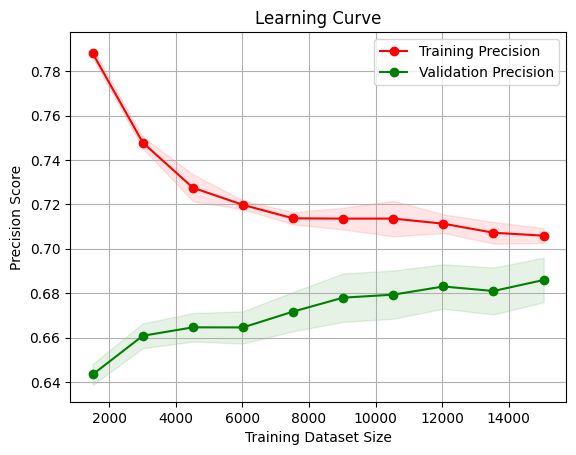

In [11]:
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Dataset Size")
plt.ylabel("Precision Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Precision")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Precision")

plt.legend(loc="best")
plt.show()